<a href="https://colab.research.google.com/github/leedain0301/Data_MiniProject_02/blob/main/MiniProject_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 컬럼 설명

#   train.csv / test.csv <br>
>  : 서울/부산 지역의 1,100,000여개 거래 데이터, 아파트 거래일, 지역, 전용면적, 실 거래가 등의 정보

- **features**
  *   transaction_id : 아파트 거래 유일키키
  *   apartment_id : 아파트 아이디
  *   city : 도시
  *   dong : 동
  *   jibun : 지번
  *   apt : 아파트단지 이름
  *   addr_kr : 주소
  *   exclusive_use_area : 전용면적
  *   year_of_completion : 설립일자
  *   transaction_year_month : 거래년월
  *   transaction_date : 거래날짜
  *   floor : 층
  *   transaction_real_price : 실거래가(train 만 존재)


#   park.csv<br>
>  : 서울/부산 지역의 공원에 대한 정보

- **features**

  *  city : 도시 이름
  *  gu : 구
  *  dong : 동
  *  park_name : 공원 이름
  *  park_type : 공원 이름
  *  park_area : 공원의 넓이
  *  park_exercise_facility : 공원보유 운동시설
  *  park_entertainment_facility : 공원보유 유희시설
  *  park_benefit_facility : 공원보유 편익시설
  *  park_cultural_facitiy : 공원보유 교양시설
  *  park_facility_other : 공원보유 기타시설
  *  park_open_year : 공원 개장년도
  *  reference_date : 데이터 기준일자(해당 데이터가 기록된 일자)


# day_care_center.csv<br>
>  : 서울/부산 지역의 어린이집에 대한 정보

- **features**

  *  city : 도시 이름
  *  gu : 구
  *  dong : 동
  *  day_care_name : 어린이집 이름
  *  day_care_type : 어린이집 종류
  *  day_care_baby_num : 정원수
  *  teacher_num : 보육교직원수
  *  nursing_room_num : 보육실수
  *  playground_num : 놀이터수
  *  CCTV_num : CCTV 설치수
  *  is_commuting_vehicle : 통학차량 운영여부
  *  reference_date : 데이터 기준일자(해당 데이터가 기록된 일자)

<br>

---

<br>









In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import sklearn
import warnings
warnings.filterwarnings('ignore')
import sys

train_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/test.csv')

print('train.csv. Shape: ',train_data.shape)
print('test.csv. Shape: ', test_data.shape)

train.csv. Shape:  (1216553, 13)
test.csv. Shape:  (5463, 12)


In [2]:
train_data.drop(train_data[(train_data['city'] == '부산광역시')].index, inplace=True)
test_data.drop(test_data[(train_data['city'] == '부산광역시')].index, inplace=True)


In [3]:
train_data.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [18]:
test_data.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,1179897,11086,서울특별시,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,1223091,2121,부산광역시,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742285 entries, 0 to 1184018
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   transaction_id          742285 non-null  int64  
 1   apartment_id            742285 non-null  int64  
 2   city                    742285 non-null  object 
 3   dong                    742285 non-null  object 
 4   jibun                   742285 non-null  object 
 5   apt                     742285 non-null  object 
 6   addr_kr                 742285 non-null  object 
 7   exclusive_use_area      742285 non-null  float64
 8   year_of_completion      742285 non-null  int64  
 9   transaction_year_month  742285 non-null  int64  
 10  transaction_date        742285 non-null  object 
 11  floor                   742285 non-null  int64  
 12  transaction_real_price  742285 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 95.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 554.8+ KB


In [6]:
train_null = train_data.drop('transaction_real_price', axis=1).isnull().sum()/len(train_data)*100
test_null = test_data.isnull().sum()/len(test_data)*100
pd.DataFrame({'train_null_count': train_null,'test_null_count':test_null})

,train_null_count,test_null_count
transaction_id,0.0,0.0
apartment_id,0.0,0.0
city,0.0,0.0
dong,0.0,0.0
jibun,0.0,0.0
apt,0.0,0.0
addr_kr,0.0,0.0
exclusive_use_area,0.0,0.0
year_of_completion,0.0,0.0
transaction_year_month,0.0,0.0


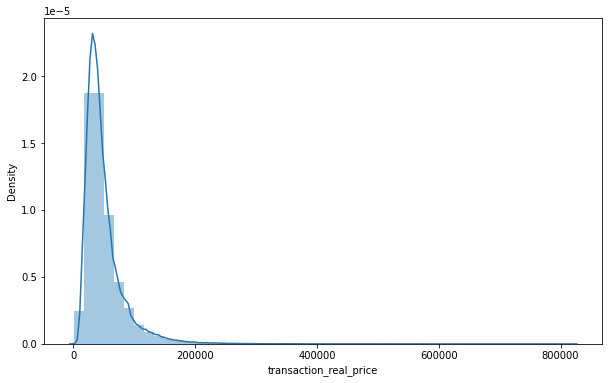

In [7]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['transaction_real_price'])

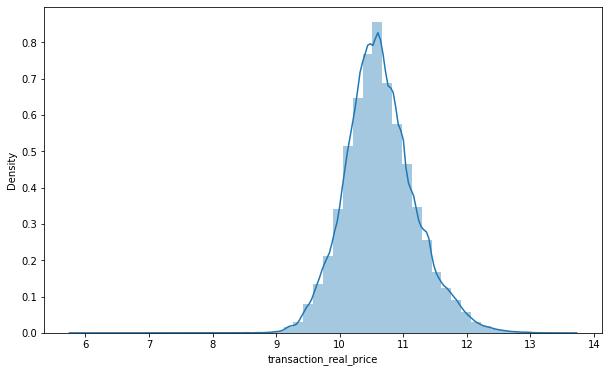

In [8]:
train_data['transaction_real_price'] = np.log1p(train_data['transaction_real_price'])
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['transaction_real_price'])

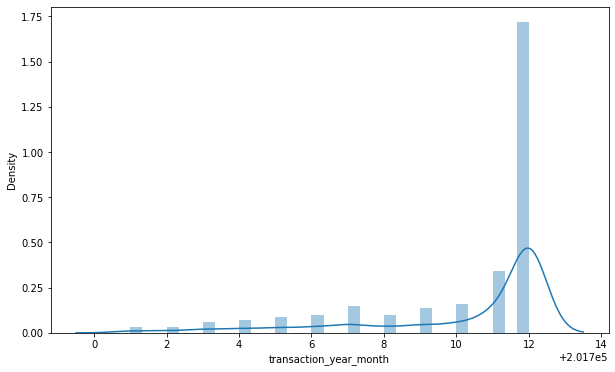

In [17]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(test_data['transaction_year_month'])

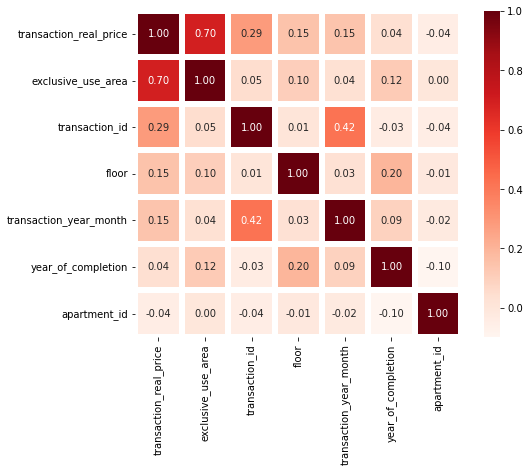

In [9]:
k = train_data.shape[1]
corrmat = train_data.corr()
cols = corrmat.nlargest(k,'transaction_real_price')['transaction_real_price'].index
cm = np.corrcoef(train_data[cols].values.T)
f,ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,
            annot = True,
            square=True,
            fmt='.2f',
            linewidths=5,
            cmap='Reds',
            yticklabels=cols.values,
            xticklabels=cols.values
            )

In [10]:
train_id = train_data['transaction_id']
train = train_data.drop('transaction_id',axis=1)
test_id = test_data['transaction_id']
test = test_data.drop('transaction_id',axis=1)

In [11]:
train['transaction_real_price'] = np.expm1(train_data['transaction_real_price'])

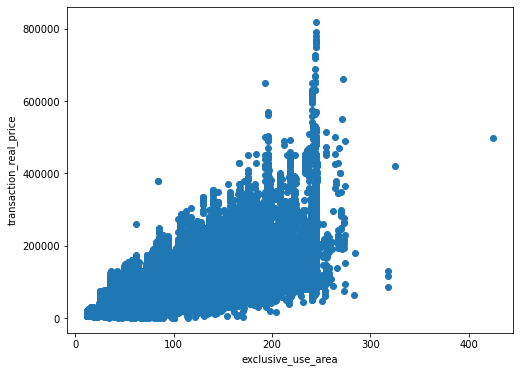

In [19]:
f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['exclusive_use_area'],train['transaction_real_price'])
plt.xlabel('exclusive_use_area')
plt.ylabel('transaction_real_price')
plt.show()

In [13]:
train[(train['exclusive_use_area'] > 400)]

,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
563870,12633,서울특별시,도곡동,193-1,힐데스하임빌라,도곡동 193-1 힐데스하임빌라,424.32,1998,201604,11~20,10,498000.0


In [ ]:
drop_columns=['apt','jibun','transaction_year_month']

train=train.drop(drop_columns,axis=1)
test=test.drop(drop_columns,axis=1)
train.head()